# TESS Data Workshop BLS Tutorial

### Getting Started

If you would like to get started with this tutorial, we recommend you have the following installed:

* `astropy` version 3.1 or higher (Python 3 compatible only)
* `lightkurve` version 1.0b26 (use `pip install lightkurve --upgrade`)


# Intro

* What is BLS?

![](http://docs.astropy.org/en/latest/stats/bls-1.pdf)

# Simple BLS Demo with astropy

### Wait what's `lightkurve`?

`lightkurve` is the Kepler/K2 GO Office package to work with NASA Kepler, K2 and TESS data. There is another workshop for you to learn the ins and outs of `lightkurve`. 

In [298]:
import lightkurve as lk

In [299]:
# Download a target

#TOI 181 (TIC 76923707)
lcf = lk.search_lightcurvefile('TIC 12862099').download()

We've now downloaded a `LightCurveFile`, which is a fits file containing multiple extensions. We'll use the `PDCSAP_FLUX` extension. This is the pipeline processed light curve, and has been corrected for long term trends.

In [300]:
lcf

TessLightCurveFile(TICID: 12862099)

In [316]:
# Get a simple test light curve
lc = lcf.PDCSAP_FLUX.remove_nans()

We can take a look at the light curve we'll be using with the `plot`, `scatter` and `errorbar` methods in `lightkurve`.

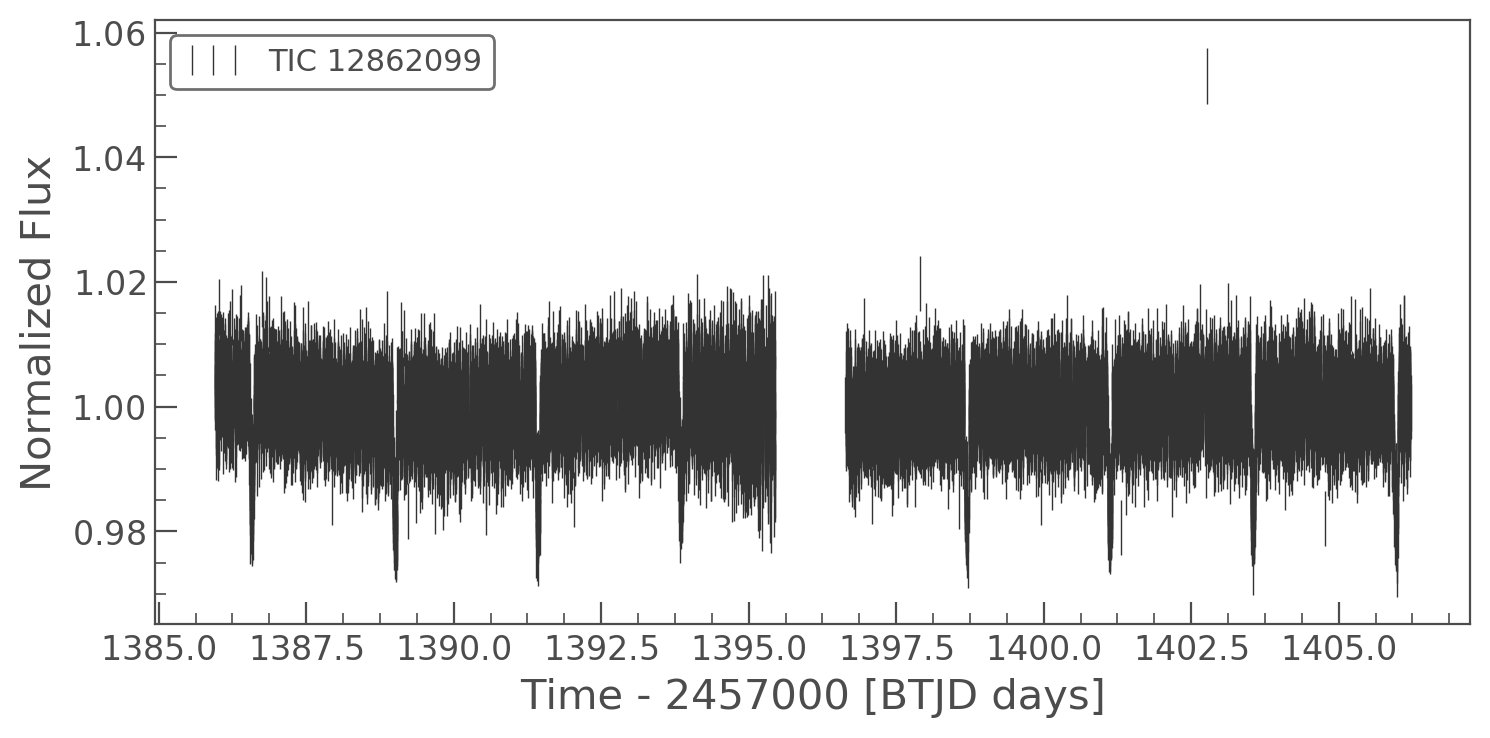

In [317]:
lc.errorbar();

This target has a long term trend, most likely due to star spot and stellar rotation. We can remove this long term trend with the `flatten` method. 

In [318]:
# Use the lightkurve flatten method
lc = lc.flatten(window_length=1701, break_tolerance=50)

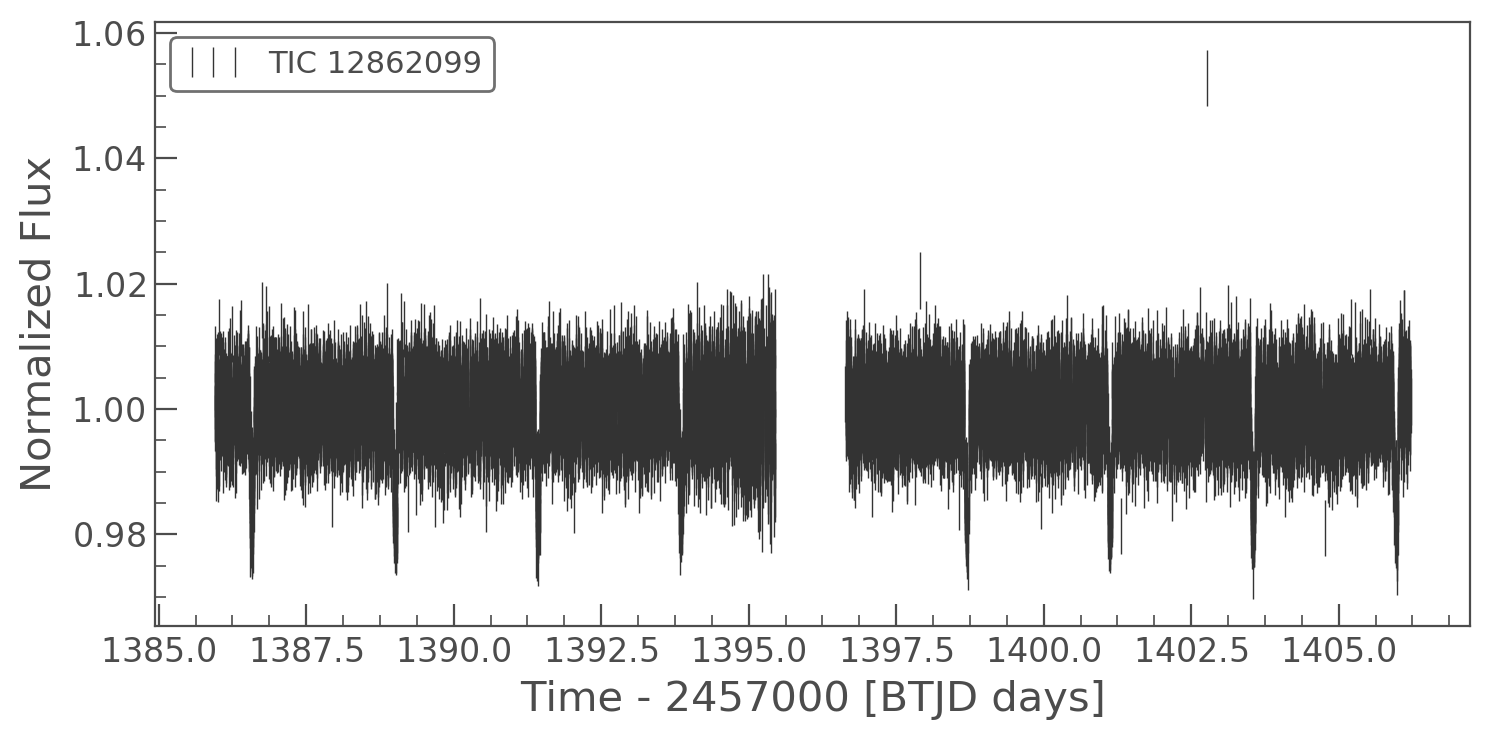

In [319]:
lc.errorbar();

Now that the light curve is flat, we can use the `BoxLeastSquares` module from astropy to search for transiting signals.

In [320]:
from astropy.stats import BoxLeastSquares
import numpy as np

In [350]:
# First, initialize a model 
model = BoxLeastSquares(lc.time, lc.flux, lc.flux_err)

# Find power at each period, for a range of durations
result = model.autopower(duration=0.05)

Now that we've calculated the power using the `autopower` function, let's look at the result.

In [351]:
result

          depth: array([9.58684332e-05, 7.17144103e-05, 7.40599676e-05, ...,
       1.57012292e-02, 1.55521372e-02, 1.57012292e-02])
      depth_err: array([7.80095089e-05, 7.79688680e-05, 7.79688548e-05, ...,
       7.40335436e-04, 7.40344796e-04, 7.40335436e-04])
      depth_snr: array([ 1.22893266,  0.91978263,  0.94986604, ..., 21.20826375,
       21.00661374, 21.20826375])
       duration: array([0.05, 0.05, 0.05, ..., 0.05, 0.05, 0.05])
 log_likelihood: array([  1.46302482,   0.84699938,   0.90317246, ..., 225.52230645,
       221.25410776, 225.52230645])
      objective: 'likelihood'
         period: array([ 0.1       ,  0.10000122,  0.10000244, ..., 10.10806675,
       10.12052209, 10.13300817])
          power: array([  1.46302482,   0.84699938,   0.90317246, ..., 225.52230645,
       221.25410776, 225.52230645])
   transit_time: array([0.02915261, 0.04227724, 0.02540146, ..., 0.95094148, 9.33762604,
       7.6170334 ])

The `result` object is a dictionary with the following keys

In [352]:
list(result.keys())

['objective',
 'period',
 'power',
 'depth',
 'depth_err',
 'duration',
 'transit_time',
 'depth_snr',
 'log_likelihood']

The period and the power where there is a good fit between the simple box model and the light curve. We can plot the periodogram easily

In [353]:
import matplotlib.pyplot as plt
plt.style.use(lk.MPLSTYLE) # Use a nice plotting style

Text(0,0.5,'Power')

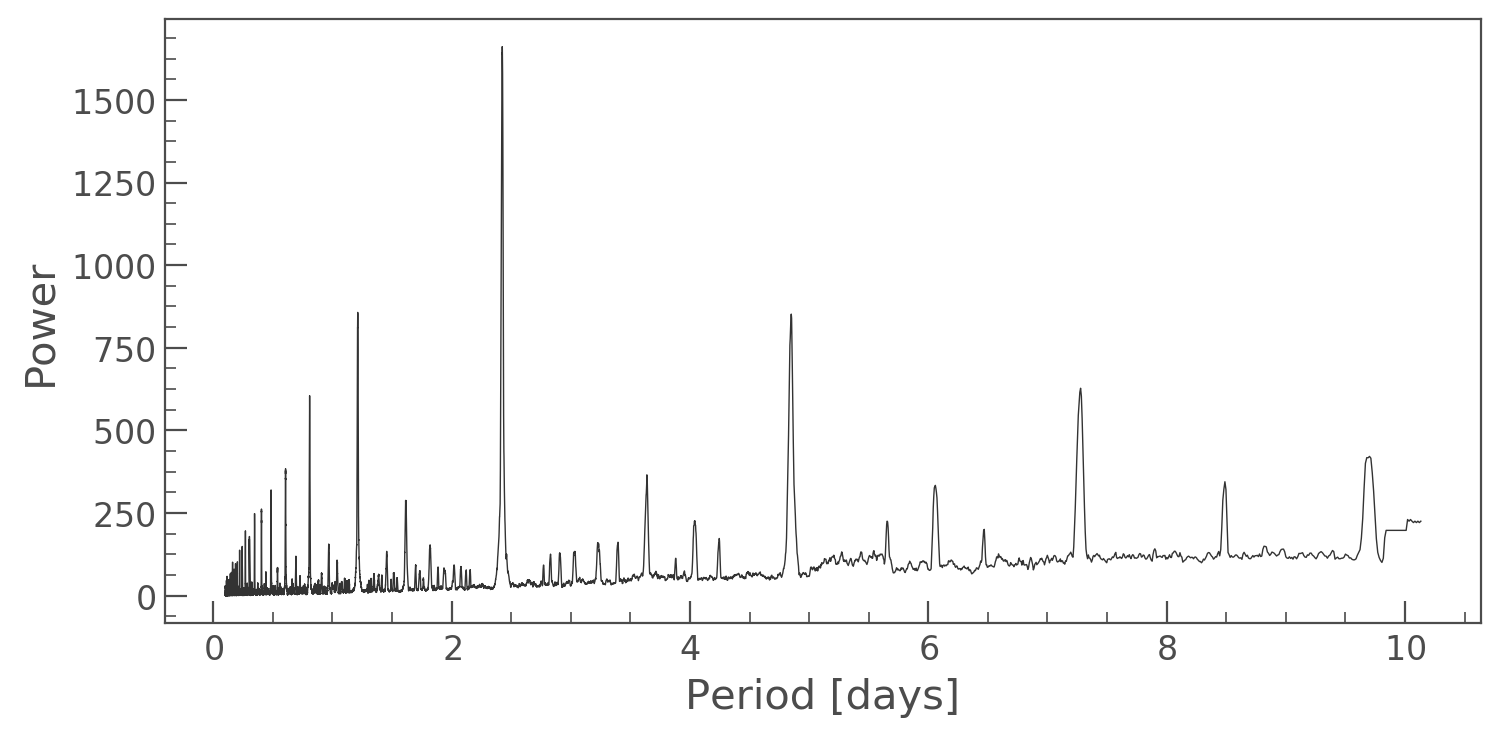

In [354]:
plt.plot(result.period, result.power);
plt.xlabel('Period [days]')
plt.ylabel('Power')

It looks like there is a trong periodicity around 5 days. Let's use the same tool to increase the period resolution around this region. Instead of using the `autopower` function, we can use the `power` function and pass our own array of periods. 

In [355]:
result = model.power(period=np.linspace(2, 3, 1000), duration=0.05)

Text(0,0.5,'Power')

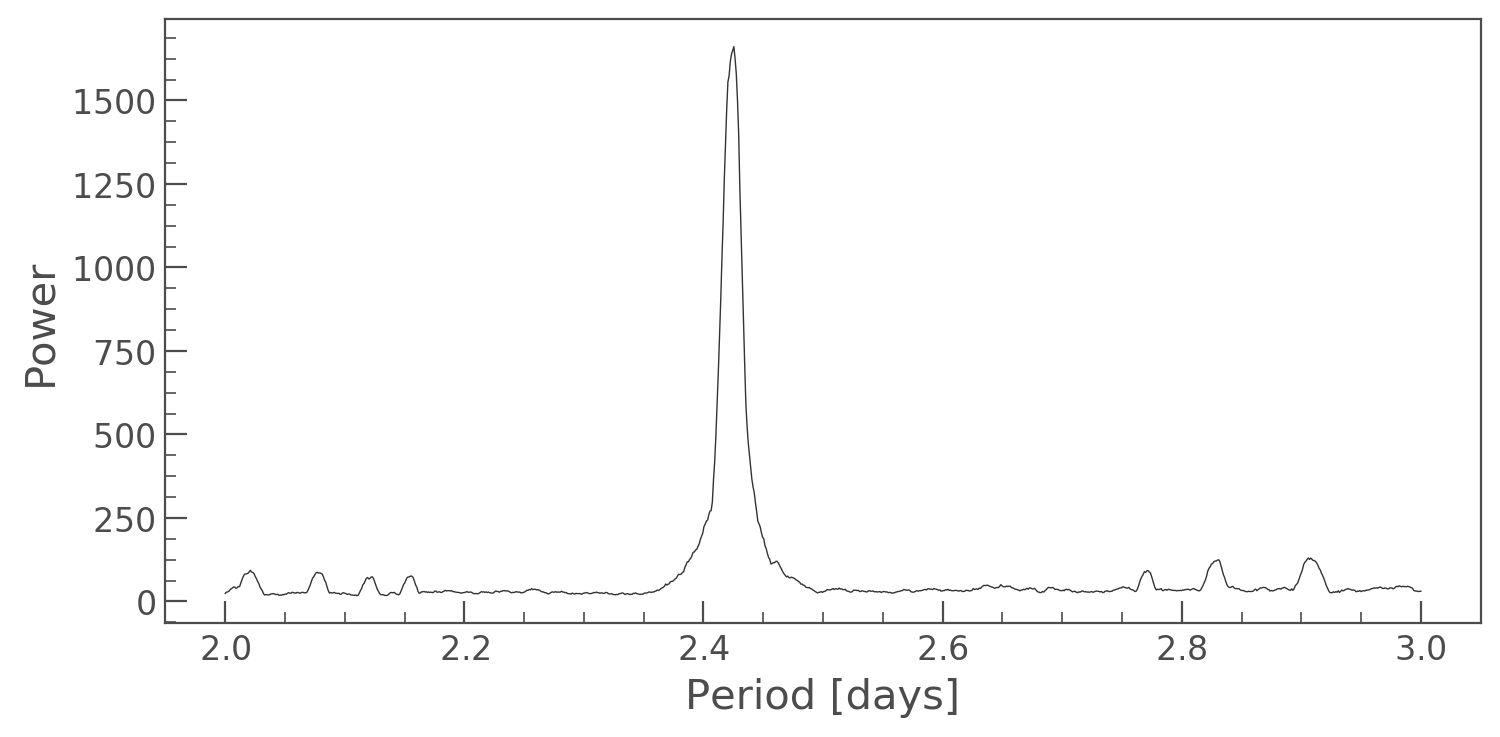

In [356]:
plt.plot(result.period, result.power);
plt.xlabel('Period [days]')
plt.ylabel('Power')

We can now find the period and transit midpoint at the peak of this distribution. This should be the period and transit midpoint that corresponds to the most significant fit between the box model and the light curve. 

In [357]:
period = result.period[np.argmax(result.power)]
t0 = result.transit_time[np.argmax(result.power)]
duration = result.duration[np.argmax(result.power)]

We can use the `lightkurve` fold method to fold the light curve and replot it

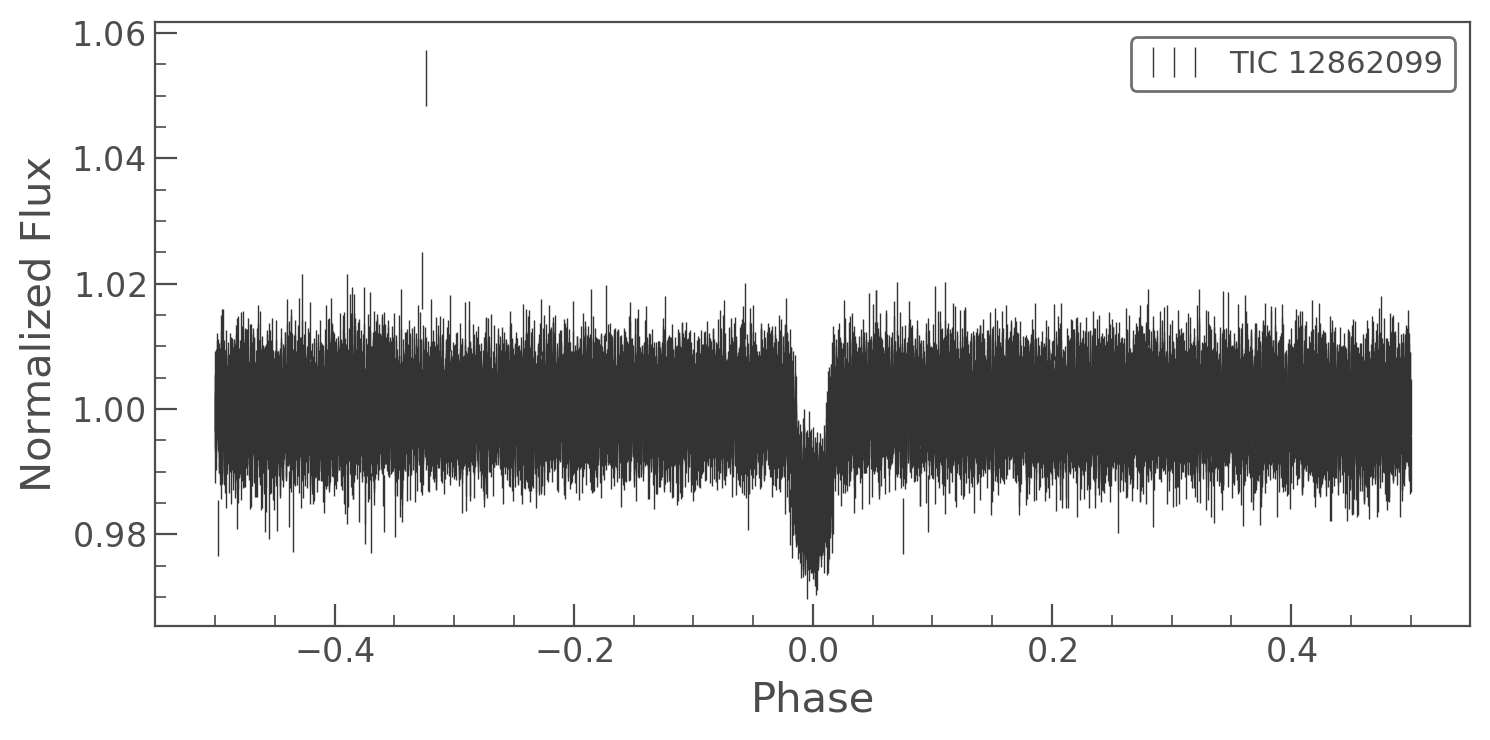

In [358]:
lc.fold(period, t0).errorbar();

We can also ue the `lightkurve` `bin` method to bin the points and look closer at the shape of the transit.

(-0.1, 0.1)

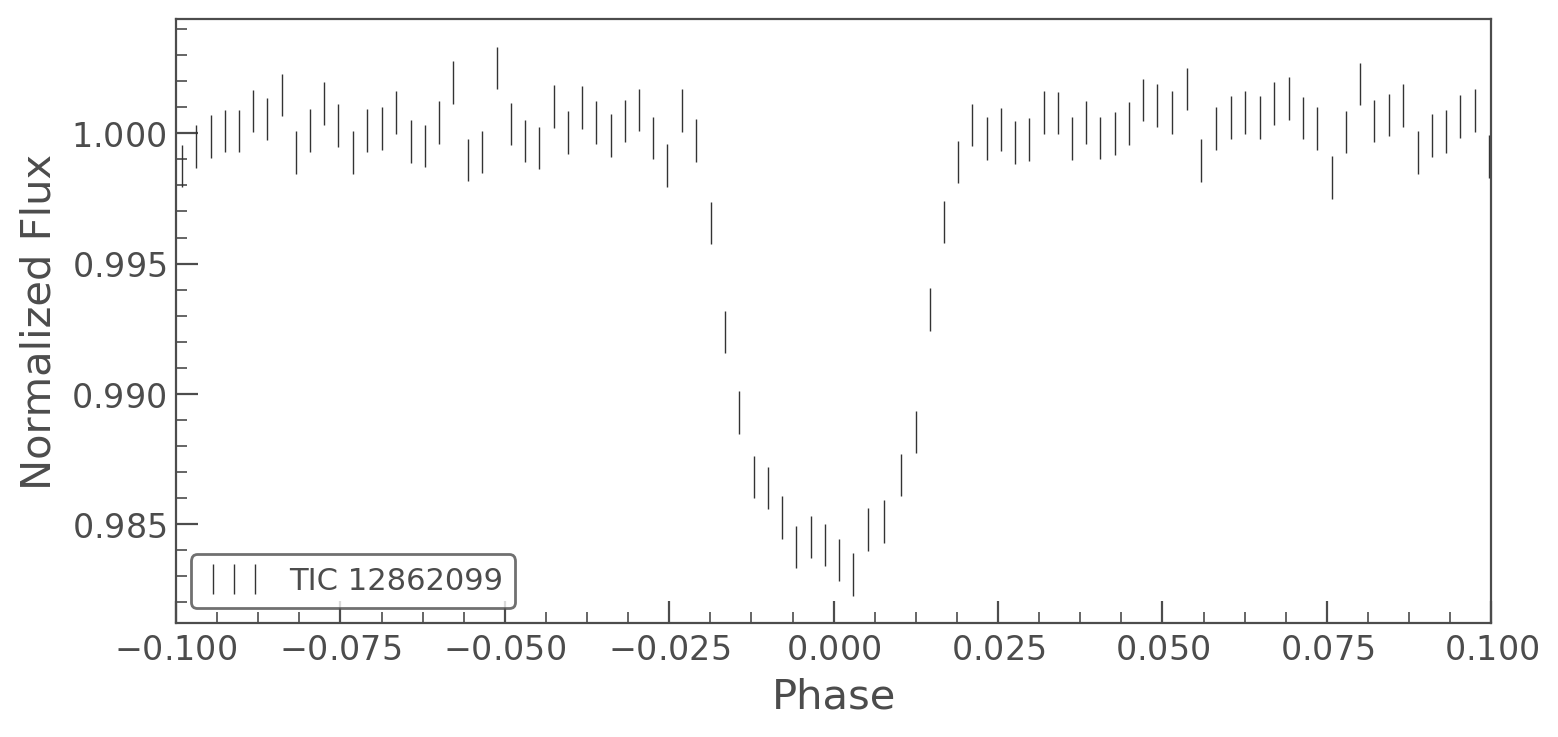

In [359]:
lc.fold(period, t0).bin(30).errorbar();
plt.xlim(-0.1, 0.1)

You can also use the BLS module to create a transit model, as demonstrated below:

In [402]:
model_flux = model.model(lc.time, period=period, duration=duration, transit_time=t0)
model_flux /= np.median(model_flux)

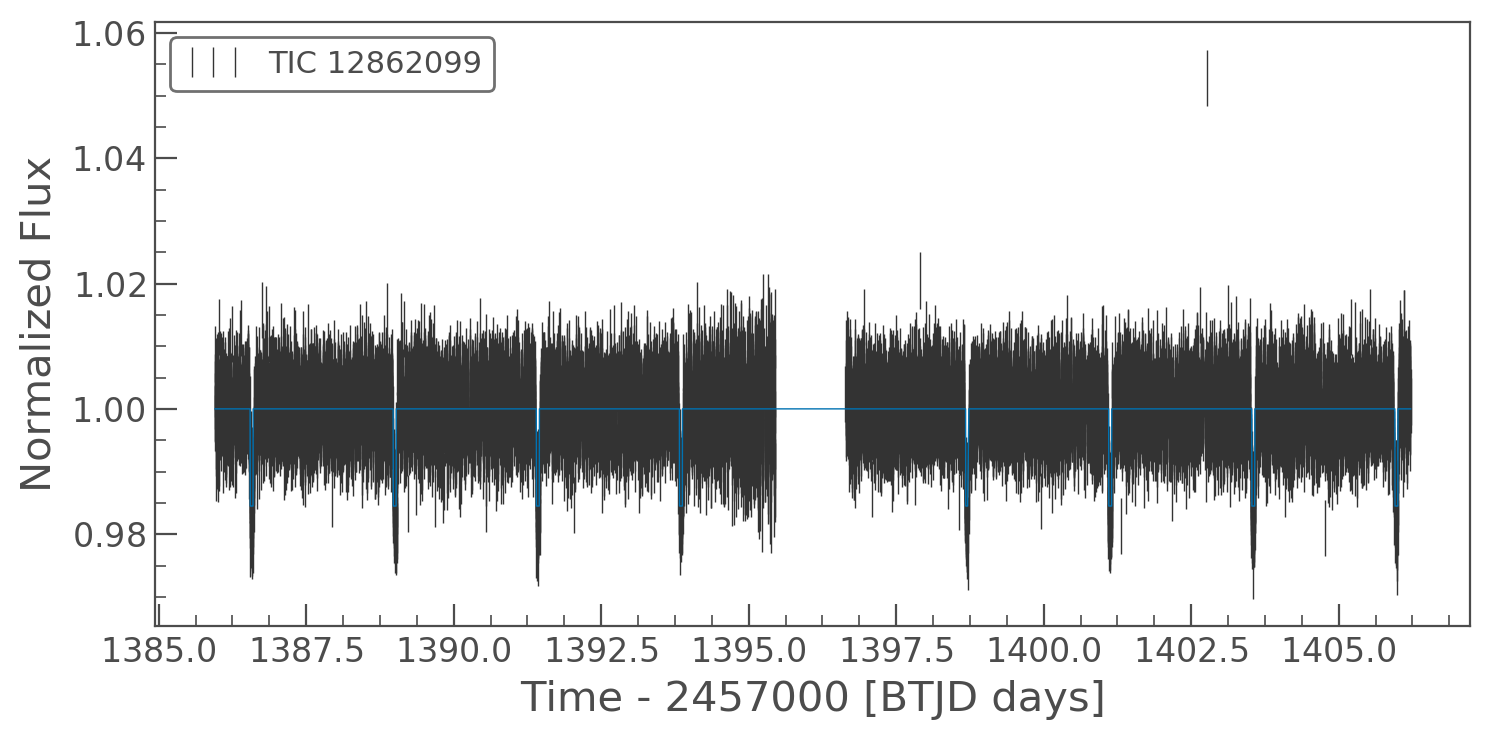

In [403]:
lc.errorbar();
plt.plot(lc.time, model_flux)

#  Compute Stats Demo

When we're attempting to validate planets, can use some handy statistics to inform us whether the transit signals are real. The BLS module allows us to access those stats very easily.

In [404]:
stats = model.compute_stats(period=period, duration=duration, transit_time=t0)

Now we have created a dictionary called `stats` which contains statistics about our model fit. **Note: We have created this dictionary by passing the period, duration and transit midpoint that we would like to evaluate the statistics at.**

### Depth Statistics

The `stats` dictionary gives us access to the best fit depth of the period, duration and transit midpoint we passed.

In [405]:
stats['depth']

(0.015502969428016211, 0.000271825368594552)

This tuple contains the depth value, and the error on the depth value.

In [406]:
depth, depth_err = stats['depth']
print('Depth = {}% +/- {}'.format(np.round(depth*100, 4), np.round(depth_err*100, 4)))

Depth = 1.5503% +/- 0.0272


We also have acces to the depth for **odd** numbered transits, and the depth of **even** numbered tranits. 

In [362]:
odd_depth, odd_depth_err = stats['depth_odd']
print('Odd Depth = {}% +/- {}'.format(np.round(odd_depth*100, 4), np.round(odd_depth_err*100, 4)))

Odd Depth = 1.5532% +/- 0.0374


In [363]:
even_depth, even_depth_err = stats['depth_even']
print('Even Depth = {}% +/- {}'.format(np.round(even_depth*100, 4), np.round(even_depth_err*100, 4)))

Even Depth = 1.5471% +/- 0.0391


In [379]:
odd_even_difference = np.abs(even_depth - odd_depth) 
odd_even_error = (even_depth_err**2 + odd_depth_err**2)**0.5
sigma = odd_even_difference/odd_even_error

print('{:.3f} Sigma Detection of Odd/Even Depths being different'.format(sigma))

0.113 Sigma Detection of Odd/Even Depths being different


* `harmonic_delta_log_likelihood`: The difference in log
likelihood between a sinusoidal model and the transit model. If `harmonic_delta_log_likelihood` is greater than zero, the sinusoidal model is preferred.

In [383]:
stats['harmonic_delta_log_likelihood']

-1542.5541075651145

In [389]:
stats['transit_times']

array([1386.57415261, 1388.99957803, 1391.42500346, 1393.85042888,
       1396.27585431, 1398.70127974, 1401.12670516, 1403.55213059,
       1405.97755601])

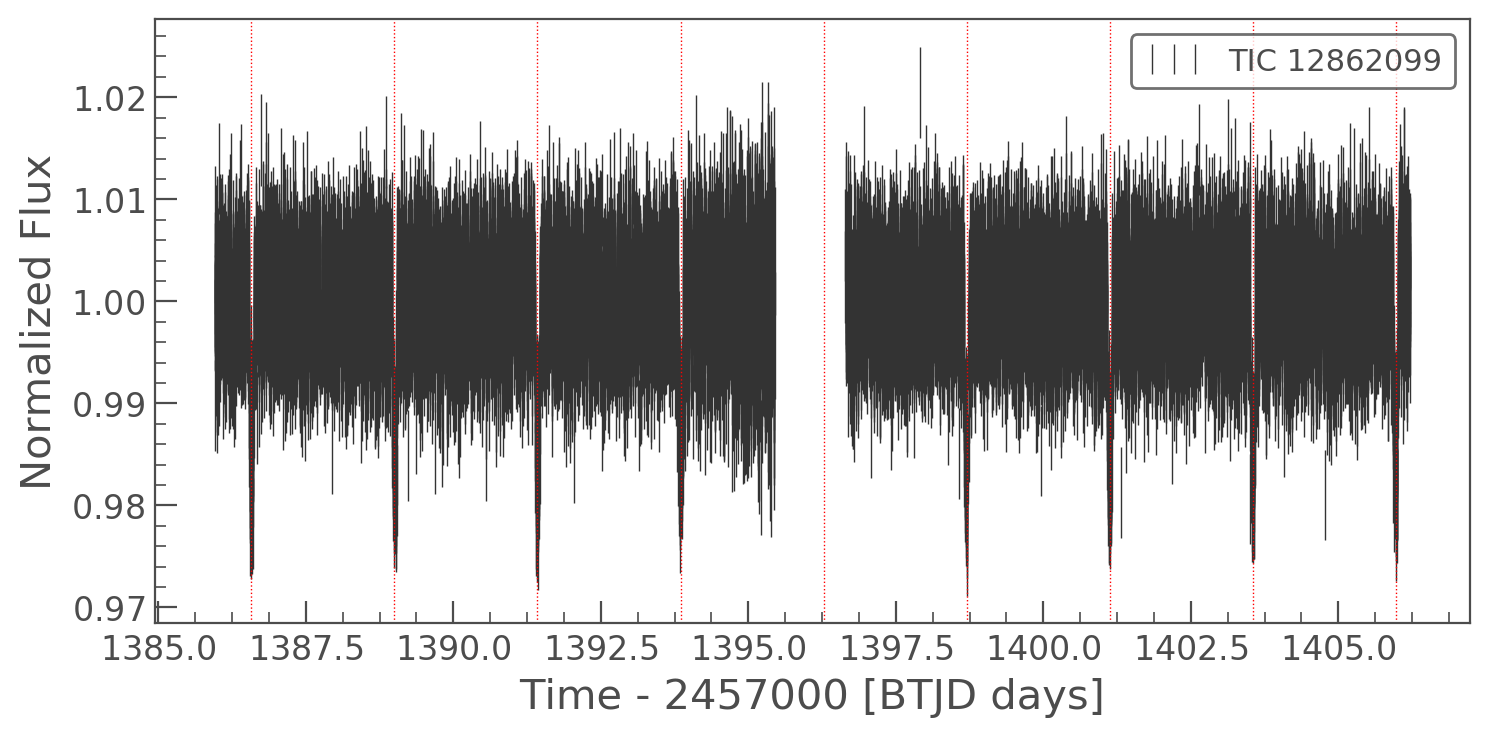

In [388]:
ax = lc.remove_outliers().errorbar()
for time in stats['transit_times']:
    ax.axvline(time, c='r', ls=':')

# Finding TWO planets with masks

# BLS Demo with lightkurve

In [9]:
lc.interact_bls('http://localhost:8889')

# Workshop Example with TESS planets, and cut out tool

# Point to other docs on other methods (including TLS)

In [77]:
import astropy

In [78]:
astropy.__version__

'3.1.1'